<a href="https://colab.research.google.com/github/ViniciusKanh/BigDataSparkIFSP/blob/main/BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

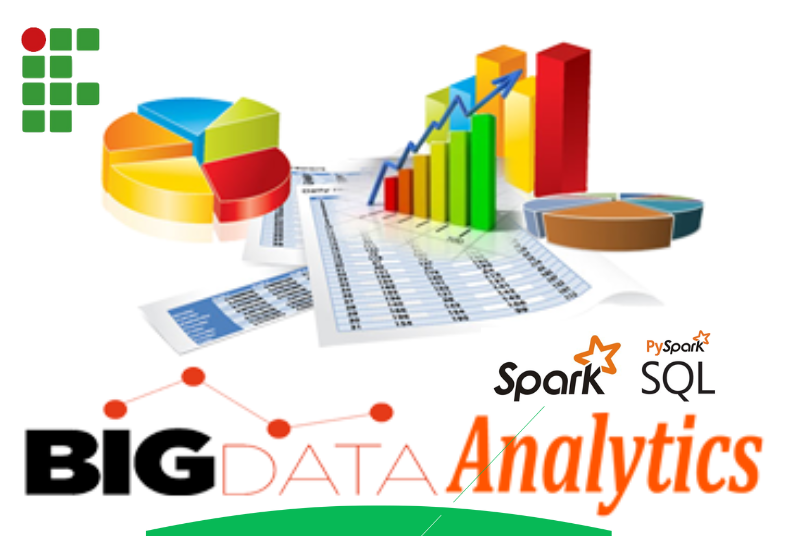

# Sistema Distribuído de Busca por Palavras-chave em Documentos PDF usando Big Data e Spark

## Resumo

Este projeto tem como objetivo desenvolver um sistema de busca por palavras-chave em documentos PDF usando Apache Spark e PyMuPDF. A busca por palavras-chave em documentos PDF é uma tarefa importante em várias aplicações, como indexação de documentos e pesquisa de informações específicas. A abordagem distribuída oferecida pelo Apache Spark permite processar grandes volumes de documentos de forma eficiente e escalável.

## Introdução

A busca eficiente por palavras-chave em documentos PDF é uma necessidade comum em muitos cenários, como gerenciamento de documentos e pesquisa de informações específicas. Este projeto se concentra em desenvolver uma solução distribuída para essa tarefa, utilizando o Apache Spark para processamento paralelo de documentos em PDF e a biblioteca PyMuPDF para extrair texto desses documentos.

## Materiais e Métodos

### Coleta de Dados

- Os documentos PDF a serem processados estão localizados em um diretório especificado. Cada documento representa uma fonte de dados para a busca por palavras-chave.

### Processamento Distribuído

- Utilizaremos o Apache Spark para processar os documentos PDF de forma distribuída. O Spark permite paralelizar o processamento em vários nós, acelerando a busca por palavras-chave.

### Extração de Texto

- A biblioteca PyMuPDF (MuPDF) será usada para abrir os documentos PDF e extrair o texto de cada página. O texto extraído será o alvo da busca por palavras-chave.

### Busca por Palavras-chave

- Definiremos uma lista de palavras-chave que desejamos encontrar nos documentos PDF. O sistema irá verificar se essas palavras estão presentes no texto extraído de cada documento.

### Resultados

- Os resultados da busca por palavras-chave serão armazenados e exibidos para o usuário. Isso incluirá informações sobre quais palavras foram encontradas em quais documentos e em qual página de cada documento.

## Objetivo

O objetivo principal deste projeto é criar uma solução distribuída para busca eficiente de palavras-chave em documentos PDF usando Apache Spark e PyMuPDF. A abordagem distribuída permitirá processar grandes volumes de documentos de forma rápida e escalável, tornando a busca por informações específicas mais eficiente.

Para atingir esse objetivo, iremos:

1. Coletar Documentos PDF: Faremos a coleta de documentos PDF de uma fonte específica, que servirão como entrada para o sistema de busca por palavras-chave.

2. Processamento Distribuído: Utilizaremos o Apache Spark para processar os documentos de forma distribuída, aproveitando o poder do processamento paralelo para acelerar a busca.

3. Extração de Texto: A biblioteca PyMuPDF será usada para extrair o texto de cada página dos documentos PDF.

4. Busca por Palavras-chave: Definiremos uma lista de palavras-chave a serem procuradas nos documentos. O sistema identificará em quais documentos e páginas essas palavras são encontradas.

5. Resultados e Exibição: Os resultados da busca serão armazenados e exibidos de forma clara e organizada, fornecendo informações úteis sobre a presença das palavras-chave nos documentos.

Este projeto tem o potencial de ser aplicado em várias áreas onde a busca por informações específicas em documentos PDF é necessária, como gerenciamento de documentos e pesquisa acadêmica.

Autor: Giovana Menato e Vinícius De Souza Santos

Githubs: https://github.com/ViniciusKanh

###     Coleta dos Documentos no Driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instalando Bibliotecas Importantes

In [ ]:
!pip install pycryptodome
!pip install pyspark
!pip install -q findspark
!pip install PyPDF2
!pip install PyMuPDF


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 20.0 MB/s eta 0:00:00


# Processo 1 - Criando o Spark e fazendo Analise dos Documentos dentro do diretorio

Bilbiotecas

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import pandas as psp
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType


Instale e Configure o Spark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

^C
^C


Configurar Variáveis de Ambiente

In [ ]:
import os

os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"



Inicie uma Sessão Spark

In [ ]:
import os
import fitz  # PyMuPDF
import pandas as pd
import json
from pyspark.sql import SparkSession
from IPython.display import HTML, display, FileLink
import shutil

# Configurar uma sessão Spark
spark = SparkSession.builder.appName("Análise de Palavras-chave").getOrCreate()

# Diretório contendo os documentos PDF
pdf_dir = "/content/drive/My Drive/Faculdade/Aula/2023.2/Sistemas Distribuidos/Trabalho de BigData/Aplicação Pratica/Documentos"

# Diretório para exportar os resultados
export_dir = "/content/drive/My Drive/Faculdade/Aula/2023.2/Sistemas Distribuidos/Trabalho de BigData/Aplicação Pratica/Dados"




Criar caso não exista o diretorio

In [ ]:
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

Função para procurar palavras específicas em um arquivo PDF

In [ ]:
def buscar_palavras_em_pdf(pdf_file_path, palavras_chave):
    try:
        # Abre o PDF e lê o texto
        pdf_document = fitz.open(pdf_file_path)

        resultados = []  # Armazenará os resultados para este PDF

        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            text = page.get_text()

            # Verifica se as palavras-chave estão presentes no texto
            for palavra in palavras_chave:
                if palavra.lower() in text.lower():
                    resultados.append(f'<p class="result"><span class="keyword">{palavra}</span> encontrada na página {page_num + 1} do arquivo <span class="filename">{pdf_file_path}</span></p>')

        return resultados

    except Exception as e:
        return [f'<p class="error">Erro ao processar o arquivo <span class="filename">{pdf_file_path}</span>: {str(e)}</p>']


Palavras-chave que você deseja buscar nos documentos PDF

In [ ]:
palavras_chave = ["Requisitos de Sistema", "Terceira Idade", "Medicos"]

Lista os arquivos PDF no diretório e busca as palavras-chave

In [ ]:
pdf_files = [pdf_file_name for pdf_file_name in os.listdir(pdf_dir) if pdf_file_name.endswith('.pdf')]


Converter a lista para um RDD Spark

In [ ]:
pdf_files_rdd = spark.sparkContext.parallelize(pdf_files)


Utilize a função buscar_palavras_em_pdf nos documentos PDF

In [ ]:
resultados = pdf_files_rdd.flatMap(lambda pdf_file_name: buscar_palavras_em_pdf(os.path.join(pdf_dir, pdf_file_name), palavras_chave))


Exportar os resultados em diferentes formatos

In [ ]:
def exportar_resultados(resultados, formato):
    if formato == 'csv':
        # Converter resultados para um DataFrame do Pandas
        df = pd.DataFrame(resultados.collect(), columns=['Resultado'])
        # Exportar para CSV
        csv_path = os.path.join(export_dir, 'resultados.csv')
        df.to_csv(csv_path, index=False)
        return csv_path
    elif formato == 'excel':
        # Converter resultados para um DataFrame do Pandas
        df = pd.DataFrame(resultados.collect(), columns=['Resultado'])
        # Exportar para Excel
        excel_path = os.path.join(export_dir, 'resultados.xlsx')
        df.to_excel(excel_path, index=False)
        return excel_path
    elif formato == 'json':
        # Converter resultados para uma lista de dicionários
        lista_resultados = resultados.collect()
        # Exportar para JSON
        json_path = os.path.join(export_dir, 'resultados.json')
        with open(json_path, 'w') as json_file:
            json.dump(lista_resultados, json_file)
        return json_path
    else:
        return 'Formato de exportação não suportado'


Crie uma saída HTML

In [ ]:
output_html = """
<style>
    .result {
        background-color: #f7f7f7;
        padding: 10px;
        margin: 10px;
        border: 1px solid #ddd;
        border-radius: 5px;
    }

    .keyword {
        font-weight: bold;
        color: #0073e6;
    }

    .filename {
        font-style: italic;
    }

    .error {
        background-color: #ffdddd;
        padding: 10px;
        margin: 10px;
        border: 1px solid #ff9999;
        border-radius: 5px;
    }

    .download-link {
        display: inline-block;
        padding: 5px 10px;
        background-color: #0073e6;
        color: white;
        text-decoration: none;
        border-radius: 5px;
        margin-right: 10px;
    }
</style>
<h2>Resultados da Busca em Documentos PDF</h2>
"""




In [ ]:
for resultado in resultados.collect():
    output_html += resultado

Adicionar links de download

In [ ]:
output_html += f"""
<div class="download-links">
    <a href="{exportar_resultados(resultados, 'csv')}" class="download-link" download>Exportar para CSV</a>
    <a href="{exportar_resultados(resultados, 'excel')}" class="download-link" download>Exportar para Excel</a>
    <a href="{exportar_resultados(resultados, 'json')}" class="download-link" download>Exportar para JSON</a>
</div>
"""

Coletar Resultados

In [ ]:
display(HTML(output_html))


# Processo 2: Visualização Gerencial das palavras Procuradas

 apresentamos uma análise de dois trechos de código distintos que complementam o projeto de análise de documentos PDF mencionado anteriormente. Esses trechos de código são responsáveis por processar os resultados da busca por palavras-chave em documentos PDF e apresentá-los de maneira eficaz, usando gráficos de barras e um relatório HTML.

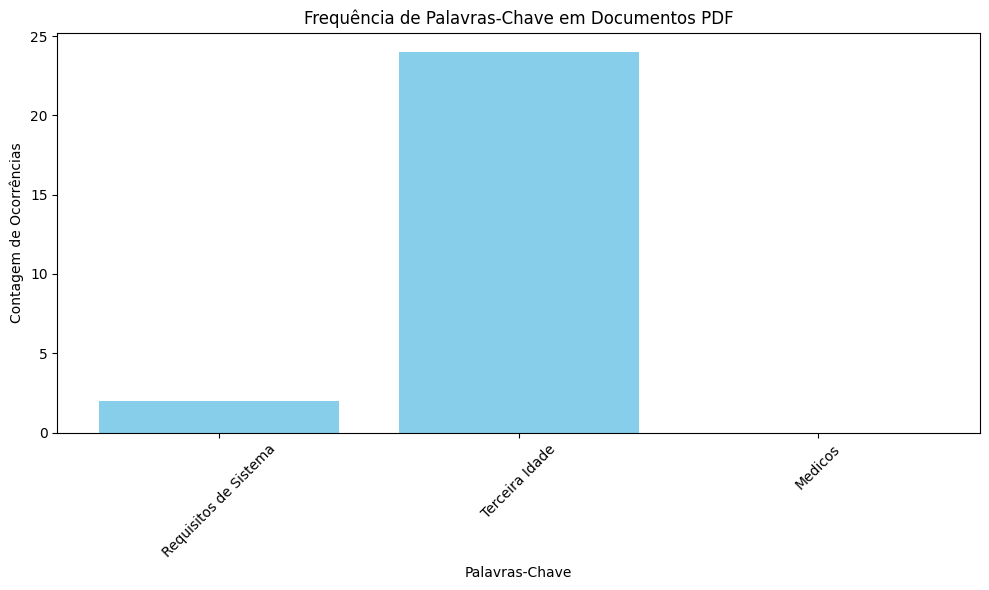

In [ ]:
import matplotlib.pyplot as plt

# Realize a busca e obtenha os resultados
resultados = pdf_files_rdd.flatMap(lambda pdf_file_name: buscar_palavras_em_pdf(os.path.join(pdf_dir, pdf_file_name), palavras_chave))

# Inicialize um dicionário para armazenar as contagens
contagens = {palavra: 0 for palavra in palavras_chave}

# Atualize as contagens com base nos resultados
for resultado in resultados.collect():
    for palavra in palavras_chave:
        if palavra.lower() in resultado.lower():
            contagens[palavra] += 1

# Crie um gráfico de barras com as contagens atualizadas
plt.figure(figsize=(10, 6))
plt.bar(contagens.keys(), contagens.values(), color='skyblue')
plt.xlabel('Palavras-Chave')
plt.ylabel('Contagem de Ocorrências')
plt.title('Frequência de Palavras-Chave em Documentos PDF')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Relevância para Projetos de Big Data e Análise de Dados Distribuída:
Este trecho de código é essencial para a análise de dados em projetos de Big Data e distribuídos, pois permite visualizar a frequência das palavras-chave em documentos PDF. As principais relevâncias incluem:

1) **Visualização de Dados:** A geração de gráficos de barras permite que os usuários visualizem rapidamente a frequência das palavras-chave, tornando mais fácil identificar tendências e padrões nos documentos PDF analisados.

2) **Tomada de Decisão Informada:** A visualização dos resultados pode auxiliar na tomada de decisões informadas em projetos de Big Data. Por exemplo, se uma palavra-chave específica aparece com frequência em documentos relacionados a um tópico, isso pode indicar sua relevância.

3) **Eficiência na Análise:** A capacidade de gerar visualizações interativas ajuda os analistas a explorar grandes volumes de dados de forma mais eficiente, permitindo que eles se concentrem nas informações mais relevantes.



Relatório de Resumo (HTML):

In [ ]:
# Suponha que você tenha um dicionário com as contagens de palavras-chave
contagens_palavras_chave = {}  # Inicialize um dicionário vazio

# Preencha o dicionário com as contagens reais das palavras-chave
for palavra in palavras_chave:
    contagens_palavras_chave[palavra] = resultados.filter(lambda resultado: palavra in resultado).count()

# Crie um relatório de resumo em HTML
html_report = """
<!DOCTYPE html>
<html>
<head>
    <title>Relatório de Resumo</title>
</head>
<body>
    <h1>Relatório de Resumo - Palavras-Chave em Documentos PDF</h1>
    <table>
        <tr>
            <th>Palavra-Chave</th>
            <th>Contagem de Ocorrências</th>
        </tr>
"""

for palavra, contagem in contagens_palavras_chave.items():
    html_report += f"""
        <tr>
            <td>{palavra}</td>
            <td>{contagem}</td>
        </tr>
    """

html_report += """
    </table>
</body>
</html>
"""

# Salve o relatório em um arquivo HTML
with open('relatorio.html', 'w') as f:
    f.write(html_report)

print("Relatório de resumo gerado com sucesso em 'relatorio.html'.")


Relatório de resumo gerado com sucesso em 'relatorio.html'.


In [ ]:
from IPython.display import HTML

# Lê o conteúdo do arquivo HTML
with open('relatorio.html', 'r') as f:
    html_content = f.read()

# Exibe o conteúdo HTML no Colab Notebook
HTML(html_content)

Palavra-Chave,Contagem de Ocorrências
Requisitos de Sistema,2
Terceira Idade,24
Medicos,0


### **Relevância para Projetos de Big Data e Análise de Dados Distribuída:**
Este trecho de código é valioso para projetos de Big Data e análise distribuída de dados devido aos seguintes aspectos:

1) **Sumarização de Dados: **A geração de um relatório HTML fornece uma forma eficaz de sumarizar as contagens de palavras-chave em documentos PDF. Isso é útil para apresentar resultados de análises complexas de maneira compreensível.

2) **Compartilhamento de Resultados:** O relatório gerado pode ser compartilhado com outras partes interessadas ou equipes de projeto, facilitando a comunicação e a colaboração em análises de Big Data.

3) **Automação: **A criação automática de relatórios HTML permite que os resultados sejam atualizados de forma eficiente à medida que novos dados são analisados, tornando o processo escalável em projetos de grande escala.

4) **Padronização:** Os relatórios em HTML fornecem uma estrutura padronizada para apresentação de resultados, tornando a análise mais consistente e facilitando a interpretação.

Esses trechos de código complementam a análise de dados em projetos de Big Data, tornando os resultados mais acessíveis e úteis para as partes interessadas, ao mesmo tempo em que automatizam parte do processo de análise de dados distribuída.

## Processo 3: Analise atraves de Filtros

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Defina uma função para atualizar os resultados com base na palavra-chave selecionada
def update_results(palavra_chave_selecionada):
    resultados = pdf_files_rdd.flatMap(lambda pdf_file_name: buscar_palavras_em_pdf(os.path.join(pdf_dir, pdf_file_name), [palavra_chave_selecionada]))

    output_html = f"""
    <style>
        .result {{
            background-color: #f7f7f7;
            padding: 10px;
            margin: 10px;
            border: 1px solid #ddd;
            border-radius: 5px;
        }}

        .keyword {{
            font-weight: bold;
            color: #0073e6;
        }}

        .filename {{
            font-style: italic;
        }}

        .error {{
            background-color: #ffdddd;
            padding: 10px;
            margin: 10px;
            border: 1px solid #ff9999;
            border-radius: 5px;
        }}
    </style>
    <h2>Resultados da Busca por Palavra-Chave: {palavra_chave_selecionada}</h2>
    """

    for resultado in resultados.collect():
        output_html += resultado

    display(HTML(output_html))

Crie um widget de seleção de palavra-chave

In [ ]:
palavra_chave_widget = widgets.Dropdown(
    options=palavras_chave,
    description='Palavra-Chave:',
    disabled=False,
)

# Associe o widget à função de atualização
widgets.interactive(update_results, palavra_chave_selecionada=palavra_chave_widget)

interactive(children=(Dropdown(description='Palavra-Chave:', options=('Requisitos de Sistema', 'Terceira Idade…


* **Interatividade:** O uso de widgets interativos permite que os usuários escolham uma palavra-chave específica e visualizem imediatamente os resultados relacionados. Isso torna a análise de grandes volumes de dados mais flexível e centrada no usuário.

* **Apresentação Visual:** A formatação HTML dos resultados torna a apresentação dos dados mais atraente e legível. Isso é fundamental para comunicar eficazmente as informações extraídas dos documentos PDF.

* **Acessibilidade: **Os widgets e a formatação HTML tornam a análise de documentos PDF acessível a um público mais amplo, incluindo aqueles que podem não estar familiarizados com linguagens de programação ou análise de dados.

* **Personalização:** Os usuários têm a flexibilidade de escolher a palavra-chave que desejam investigar, permitindo uma análise mais personalizada e direcionada.

* **Eficiência:** A capacidade de atualizar os resultados de forma dinâmica economiza tempo e esforço, pois os usuários podem iterar rapidamente na busca por informações específicas.


# Processo 4: Upload e Análise de Documentos PDF

O código em questão é um exemplo prático de Python que realiza a análise de documentos PDF em busca de palavras-chave específicas. Ele utiliza várias bibliotecas, como fitz (também conhecida como PyMuPDF), ipywidgets, e IPython.display, para criar uma experiência interativa de upload e análise de documentos PDF.

A função principal deste código é buscar palavras-chave em documentos PDF. Ela recebe o conteúdo de um PDF, abre o documento, extrai o texto de cada página e verifica se as palavras-chave fornecidas estão presentes no texto. Caso uma palavra-chave seja encontrada, a função registra a página onde ela aparece e gera um resultado correspondente.

Outra função importante é aquela responsável pelo tratamento de uploads. Quando um usuário carrega um arquivo PDF, esta função extrai o conteúdo do PDF e aciona a função de busca de palavras-chave. Os resultados são então exibidos de forma organizada em uma interface interativa.

O código inclui um botão de upload estilizado, proporcionando uma experiência mais amigável ao usuário. Esse botão, criado com a ajuda da biblioteca ipywidgets, permite ao usuário fazer o upload de um único arquivo PDF para análise.

Relevância para Projetos de Big Data e Análise de Dados Distribuída:

Este código é relevante para projetos de Big Data e análise de dados distribuída em diversas maneiras:

1) **Processamento de Dados Não Estruturados:** Em projetos de Big Data, é comum lidar com uma variedade de dados não estruturados, incluindo documentos PDF. Esta implementação demonstra como processar eficientemente esse tipo de dado, convertendo-o em informações valiosas.

2) **Análise de Texto:** A capacidade de buscar palavras-chave em documentos PDF é crucial para a análise de texto em projetos de Big Data. Isso é útil para identificar tendências, padrões e informações relevantes em grandes volumes de documentos.

3) **Interface de Usuário Amigável:** A criação de uma interface interativa para a análise de documentos facilita a interação dos usuários com os dados. Isso é especialmente importante em projetos de Big Data, onde diferentes partes interessadas podem precisar acessar e analisar informações de forma eficaz.

4) **Adaptação para Análise Distribuída:** Embora o código em si não seja distribuído, ele pode servir como ponto de partida para projetos de análise de dados distribuída. A função de busca de palavras-chave pode ser otimizada e escalonada para processar vários documentos PDF em paralelo, aproveitando estruturas como o Apache Spark para análise de Big Data.

Em resumo, este código oferece uma base sólida para a análise de documentos PDF em projetos de Big Data e pode ser estendido para atender às necessidades de análise distribuída em grande escala. Ele exemplifica como as tecnologias Python e suas bibliotecas podem ser aplicadas de forma eficaz em projetos de análise de dados.

In [ ]:
import fitz  # PyMuPDF
from IPython.display import HTML, display
import ipywidgets as widgets
from IPython.display import display as ipydisplay

# Função para buscar palavras em um PDF
def buscar_palavras_em_pdf(pdf_content, palavras_chave):
    try:
        # Abre o PDF e lê o texto
        pdf_document = fitz.open(stream=pdf_content, filetype="pdf")

        resultados = []  # Armazenará os resultados para este PDF

        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            text = page.get_text()

            # Verifica se as palavras-chave estão presentes no texto
            for palavra in palavras_chave:
                if palavra.lower() in text.lower():
                    resultados.append(f'<p>{palavra} encontrada na página {page_num + 1} deste PDF</p>')

        return resultados

    except Exception as e:
        return [f'<p>Erro ao processar o arquivo PDF: {str(e)}</p>']

# Função para lidar com o upload de um arquivo
def handle_upload(change):
    uploaded = change['new']
    if len(uploaded) > 0:
        pdf_filename = next(iter(uploaded))
        pdf_content = uploaded[pdf_filename]['content']

        # Realize a análise de palavras-chave (substitua pelas suas funções)
        resultados = buscar_palavras_em_pdf(pdf_content, palavras_chave)

        # Exiba os resultados de forma organizada
        output_html = """
        <style>
            .result {
                background-color: #f7f7f7;
                padding: 10px;
                margin: 10px;
                border: 1px solid #ddd;
                border-radius: 5px;
            }
        </style>
        <h2>Resultados da Busca em Documento PDF</h2>
        """
        for resultado in resultados:
            output_html += resultado

        display(HTML(output_html))
    else:
        print("Nenhum arquivo PDF foi carregado.")

# Crie um botão de upload estilizado
upload_button = widgets.FileUpload(
    accept='.pdf',  # Aceita apenas arquivos PDF
    multiple=False,  # Permita fazer upload de apenas um arquivo por vez
    description='Faça o Upload'
)

# Associe o botão à função de handle_upload
upload_button.observe(handle_upload, names='value')

# Exiba o botão de upload
ipydisplay(upload_button)


FileUpload(value={}, accept='.pdf', description='Faça o Upload de um PDF')

## Processo 5: Comentários e Anotações aos resultados

In [ ]:
import fitz  # PyMuPDF
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
from ipywidgets import FileUpload

# Dicionário para armazenar os comentários e anotações associados às palavras-chave
comentarios_anotacoes = {}

# Função para buscar palavras em um PDF
def buscar_palavras_em_pdf(pdf_content, palavras_chave):
    try:
        # Abre o PDF e lê o texto
        pdf_document = fitz.open(stream=pdf_content, filetype="pdf")

        resultados = []  # Armazenará os resultados para este PDF

        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            text = page.get_text()

            # Verifica se as palavras-chave estão presentes no texto
            for palavra in palavras_chave:
                if palavra.lower() in text.lower():
                    resultados.append(f'<p>{palavra} encontrada na página {page_num + 1} deste PDF</p>')

        return resultados

    except Exception as e:
        return [f'<p>Erro ao processar o arquivo PDF: {str(e)}</p>']

# Função para lidar com o upload de um arquivo
def handle_upload(change):
    clear_output()  # Limpa a saída para evitar duplicação
    uploaded = change['new']
    if len(uploaded) > 0:
        pdf_filename = next(iter(uploaded))
        pdf_content = uploaded[pdf_filename]['content']

        # Realize a análise de palavras-chave (substitua pelas suas funções)
        resultados = buscar_palavras_em_pdf(pdf_content, palavras_chave)

        # Exiba os resultados de forma organizada
        output_html = """
        <style>
            .result {
                background-color: #f7f7f7;
                padding: 10px;
                margin: 10px;
                border: 1px solid #ddd;
                border-radius: 5px;
            }
        </style>
        <h2>Resultados da Busca em Documento PDF</h2>
        """
        for resultado in resultados:
            output_html += resultado

        # Adicione uma área para comentários e anotações
        output_html += """
        <h2>Comentários e Anotações</h2>
        <textarea id="comentario" rows="4" cols="50" placeholder="Adicione seu comentário ou anotação aqui..."></textarea>
        <button onclick="adicionarComentario()">Adicionar Comentário</button>
        <div id="comentarios"></div>
        <script>
        function adicionarComentario() {
            var comentario = document.getElementById("comentario").value;
            var comentariosDiv = document.getElementById("comentarios");
            comentariosDiv.innerHTML += "<p>" + comentario + "</p>";
            document.getElementById("comentario").value = "";
        }
        </script>
        """

        display(HTML(output_html))
    else:
        print("Nenhum arquivo PDF foi carregado.")

# Crie um botão de upload estilizado
upload_button = FileUpload(
    accept='.pdf',  # Aceita apenas arquivos PDF
    multiple=False,  # Permita fazer upload de apenas um arquivo por vez
    description='Faça o Upload'
)

# Associe o botão à função de handle_upload
upload_button.observe(handle_upload, names='value')

# Exiba o botão de upload
display(upload_button)


Encerra a sessão Spark

In [ ]:
spark.stop()